# Study of the 2020 COVID Lockdown (February-July) using the TROPESS Chemical Reanalysis (TCR) Version 2 Download and Analysis Notebook

**Summary:**

This code reads **TROPESS Chemical Reanalysis Surface Total NOx emissions Monthly 2-dimensional Product V1 (TRPSCRENOXTM2D)** data products for February to July 2020 directly using HTTPS-based download from **NASA Earthdata (GES DISC)** and makes a monthly data plots for monthly comparison.

For continued, seamless operation, a **.netrc** file containing an individual user's **NASA Earthdata Login** credentials (not supplied with this notebook) **should** be provided by each user intending to operate this notebook from their own AWS cloud environment; in the event a .netrc file is not provided in advance, this notebook features an interactive prompt for users to manually enter their own credentials (note: the user-entered credentials are one-time use to operate this notebook and are not stored in memory). 

Below are the steps to creating a **.netrc** file and approving API-based access to the **NASA GES DISC Archvie**. Please note, **Step 2** below is **required** in advance for **all users** to successfully execute this notebook. 

  1. Create an **Earthdata Login Account** ([clear here for details](https://urs.earthdata.nasa.gov/users/new))
  2. Approve access to the **NASA GES DISC Archive** in your Earthdata Login Profile ([click here for details](https://disc.gsfc.nasa.gov/earthdata-login))
  3. Create/modify a **.netrc** file in your home directory containing your **Earthdata Login** credentials as shown below:
     <br>`machine urs.earthdata.nasa.gov login <your username> password <your password>`

**Important:** Before execiuting this notebook, please create a **'data'** and an **'images_average'** folder in the working directory of your notebook. 

**Other important notes:**

  1. This code was designed and tested **"as-is"** to run directly within either an **AWS cloud-based Jupyter Hub** environment or a local **JupyterLab** environment.
  2. All dependencies within this notebook are also available in the latest [**environment.yml**](https://github.com/NASA-TROPESS/binders/blob/main/environment.yml) file, which may be **optionally** used alongside this notebook to create, maintain and activate a dedicated conda environment (**tropess-env**) and Python notebook kernel. 
  3. Please "trust" this notebook before executing; this will prevent errors when writing output to your local directory.

## Notebook Author / Affiliation

David F. Moroni (david.f.moroni@jpl.nasa.gov) / Jet Propulsion Laboratory, Californa Institute of Technology

### Date Authored

3 June 2024

### List of Updates since Original Notebook

  1. Create the local output directory paths if they do not already exist.
  2. Removed requirement to have .netrc file (and credentials) supplied by the user prior to notebook execution.
  3. Interactive user prompt to enter NASA Earthdata Login credentials (if not already provided in .netrc file).
  4. Verification of .netrc NASA Earthdata Login credentials.
  5. Utilization of NASA **earthaccess** Python library functions to support authentication to NASA Earthdata.
  6. Add timer to all cells.
  7. Consolidate import statements to the first cell and remove duplicate import statements.
  8. Updated guidance notes.

### Collaborators
Kazuyuki Miyazaki (kazuyuki.miyazaki@jpl.nasa.gov) / Jet Propulsion Laboratory, Californa Institute of Technology

### Acknowledgements

The research was carried out at the Jet Propulsion Laboratory, California Institute of Technology, under a contract with the National Aeronautics and Space Administration (80NM0018D0004). Government sponsorship acknowledged.

In [1]:
%%time

import requests

import earthaccess
from earthaccess import Auth, Store, DataCollections, DataGranules
auth = Auth()

import os
import datetime
import contextlib

from pathlib import Path

import pandas as pd

import numpy as np
import netCDF4
from netCDF4 import Dataset,num2date,date2num

import matplotlib.pyplot as plt

import imageio.v2 as imageio

from mpl_toolkits.basemap import Basemap

from scipy.interpolate import griddata
from scipy.spatial import cKDTree

CPU times: user 1.43 s, sys: 181 ms, total: 1.61 s
Wall time: 1.53 s


# Verify Successful Authentication to NASA Earthdata¶
Prompt for NASA Earthdata Login Credentials (if .netrc file doesn't already exist)
A .netrc file will be created if it doesn't already exist.

In [2]:
%%time

# Using earthacces library to provide interactie authentication.
auth = earthaccess.login(strategy="interactive", persist=True)

auth.login(strategy="netrc")
authvalid = auth.authenticated
print('Authenication Valid =',authvalid)

# The Store() class enables download or access to data and is instantiated with the user's auth instance.
store = Store(auth)

Authenication Valid = True
CPU times: user 93.5 ms, sys: 2.31 ms, total: 95.8 ms
Wall time: 2.34 s


# Now we will create the local output directory paths if they do not already exist.

In [3]:
data_dir_check = os.path.isdir('data')
print("Data directory exists: ",data_dir_check)

images_dir_check = os.path.isdir('images')
print("Images directory exists: ",images_dir_check)

if data_dir_check != True: os.makedirs('data')
if images_dir_check != True: os.makedirs('images')

Data directory exists:  True
Images directory exists:  True


# Create a Function for CMR Catalog Requests

In [4]:
def cmr_request(params):
    response = requests.get(url,
                        params=params,
                        headers={
                            'Accept': 'application/json',
                        }
                       )
    return response

# Search CMR Catalogs and Obtain S3 URLs
## Check that the CMR catalog can be accessed

If "200, CMR is accessible" is returned, the catalog can be accessed!

In [5]:
%%time

url = 'https://cmr.earthdata.nasa.gov/search/collections'

# Create our request for finding cloud-hosted granules, and check that we can access CMR
response = cmr_request({
                        'cloud_hosted': 'True',
                        'has_granules': 'True'
                        })

if response.status_code == 200:
    print(str(response.status_code) + ", CMR is accessible")
else:
    print(str(response.status_code) + ", CMR is not accessible, check for outages")

200, CMR is accessible
CPU times: user 12.8 ms, sys: 3.82 ms, total: 16.6 ms
Wall time: 968 ms


# Use EarthAccess to Search CMR with your desired data collection's shortname, bounding box and desired date range

Using the collection's shortname or concept ID, we can obtain individual granules by directly querying the CMR API.

From the CMR query, we will parse out an S3 URL for the "TROPESS CrIS-JPSS1 L2 Carbon Monoxide for Forward Stream, Summary Product V1" dataset.

   **Shortname**: TRPSCRENOXTM2D  
   **Concept ID**: C2837624983-GES_DISC

Our desried date range is February 1, 2020 00:00:00 to July 31, 2020 23:59:59.

In [6]:
%%time

# Initial CMR Query
query = DataGranules().short_name("TRPSCRENOXTM2D").temporal("2020-02-01", "2020-07-31")
# How many granules are located in the query?
print(f"Granule hits: {query.hits()}")

# Extract all available granule metadata from the query; invoking "-1" for all avaialble granules.
granules = query.get()

# Print granule metadata
print(granules)

Granule hits: 1
[Collection: {'ShortName': 'TRPSCRENOXTM2D', 'Version': '1'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -180.0, 'EastBoundingCoordinate': 180.0, 'NorthBoundingCoordinate': 90.0, 'SouthBoundingCoordinate': -90.0}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2020-01-01T00:00:00.000Z', 'EndingDateTime': '2020-12-31T23:59:59.000Z'}}
Size(MB): 1.4533185958862305
Data: ['https://data.gesdisc.earthdata.nasa.gov/data/TCR2_MON_EMISSIONS/TRPSCRENOXTM2D.1/TROPESS_reanalysis_mon_emi_nox_tot_2020.nc']]
CPU times: user 23.8 ms, sys: 5.21 ms, total: 29.1 ms
Wall time: 688 ms


### Next, Try extracting files using HTTPS; if operating outside of cloud, then specify "external" access to extract and download files to local environment.

In [7]:
%%time

try:
    files = store.get(granules[:], local_path="./data")
except Exception as e:
    print(f"Error: {e}, we are probably not using this code in the Amazon cloud. Trying external links...")
    # There is hope, even if we are not in the Amazon cloud we can still get the data
    files = store.get(granules[:], access="external", local_path="./data")

 Getting 1 granules, approx download size: 0.0 GB
Accessing cloud dataset using dataset endpoint credentials: https://data.gesdisc.earthdata.nasa.gov/s3credentials
Downloaded: data/TROPESS_reanalysis_mon_emi_nox_tot_2020.nc
CPU times: user 114 ms, sys: 50.1 ms, total: 164 ms
Wall time: 3.02 s


# Remove .netrc file

In [8]:
!rm .netrc

## Let's read the TCR-2 data file(s). 

In [9]:
%%time

#Define the target measurement variable
measurement = 'nox'

file = str(files[0])
file = './'+file

dataset = Dataset(f'{file}', 'r')
print("reading data from: ", file)

# Read the data from your variables
latitude = dataset.variables['lat'][:]
longitude = dataset.variables['lon'][:]
x_meas = dataset.variables[measurement][:]
time = dataset.variables['time']
time_bnds = dataset.variables['time_bnds']

# Convert the time variable data into an np.array indicating the YYYY-MM-DDT00:00:00 information
nptime = np.array(netCDF4.num2date(time[:], units=time.units,calendar='standard'),dtype='datetime64[s]')

# Convert the time_bnds variable data into an np.array indicating the YYYY-MM-DDT00:00:00 information
nptime_bnds = np.array(netCDF4.num2date(time_bnds[:], units=time_bnds.units,calendar='standard'),dtype='datetime64[s]')

dataset.close()

# Recast the np.array 'nptime' to a 1-D string array
dtime = nptime.astype(str)

# Print time variable coverage
print('Time coverage: ',dtime)

# Recast the np.array 'nptime' to a 1-D string array
dtime_bnds = nptime_bnds.astype(str)

# Print time_bnds variable coverage
print('Time bounds coverage: ',dtime_bnds)

# Set the plotting/analysis limits for the latitude and longitude
latitude_max = 75.0
latitude_min = -45.0
longitude_max = 360.0
longitude_min = 0.0

reading data from:  ./data/TROPESS_reanalysis_mon_emi_nox_tot_2020.nc
Time coverage:  ['2020-01-01T00:00:00' '2020-02-01T00:00:00' '2020-03-01T00:00:00'
 '2020-04-01T00:00:00' '2020-05-01T00:00:00' '2020-06-01T00:00:00'
 '2020-07-01T00:00:00' '2020-08-01T00:00:00' '2020-09-01T00:00:00'
 '2020-10-01T00:00:00' '2020-11-01T00:00:00' '2020-12-01T00:00:00']
Time bounds coverage:  [['2020-01-01T00:00:00' '2020-01-31T00:00:00']
 ['2020-02-01T00:00:00' '2020-02-29T00:00:00']
 ['2020-03-01T00:00:00' '2020-03-31T00:00:00']
 ['2020-04-01T00:00:00' '2020-04-30T00:00:00']
 ['2020-05-01T00:00:00' '2020-05-31T00:00:00']
 ['2020-06-01T00:00:00' '2020-06-30T00:00:00']
 ['2020-07-01T00:00:00' '2020-07-31T00:00:00']
 ['2020-08-01T00:00:00' '2020-08-31T00:00:00']
 ['2020-09-01T00:00:00' '2020-09-30T00:00:00']
 ['2020-10-01T00:00:00' '2020-10-31T00:00:00']
 ['2020-11-01T00:00:00' '2020-11-30T00:00:00']
 ['2020-12-01T00:00:00' '2020-12-31T00:00:00']]
CPU times: user 4.51 ms, sys: 25.7 ms, total: 30.2 ms
Wal

# Let's make a global map (45 deg South to 75 deg North) of the Feb 2020 NOX Data using Basemap. 

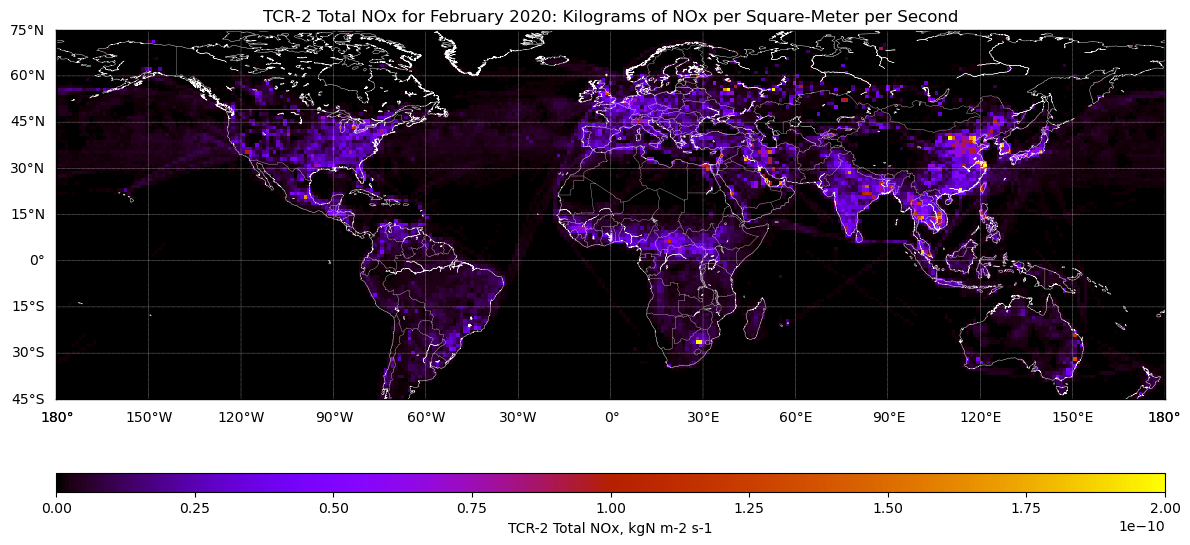

CPU times: user 1.25 s, sys: 73.2 ms, total: 1.32 s
Wall time: 1.4 s


In [10]:
%%time
# Subset data to month/year
selection = np.where(dtime == '2020-02-01T00:00:00')[0]
index = selection[0]

x_meas_feb20 = x_meas[index,:,:]

# Calculate width and height
aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
w = 3600; h = w / aspect_ratio

# Specify figure size (in inches)
dpi = 200; 
plt.figure(figsize=(w / dpi, h / dpi))  

# Create a basemap instance
m = Basemap(projection='cyl', resolution='l',
    llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
    llcrnrlon=longitude_min-180.0, urcrnrlon=longitude_max-180.0)  # set longitude limits as previously defined

m.drawmapboundary(fill_color='black')
m.drawcoastlines(linewidth=0.3, color='white')
m.drawcountries(linewidth=0.2, color='white')

# Draw parallels (latitude lines) and meridians (longitude lines)
parallels = np.arange(latitude_min, latitude_max+1, 15.)
m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3, color='white')

meridians = np.arange(longitude_min, longitude_max+1, 30.)
m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3, color='white')
 
# Plot the interpolated data using pcolormesh instead of scatter
sc = m.pcolormesh(longitude, latitude, x_meas_feb20, latlon=True, cmap='gnuplot', alpha=1.0, vmin=0.0, vmax=2.0e-10, shading='auto')
    
# Add a colorbar
cbar = m.colorbar(sc, location='bottom', pad="20%")
cbar.set_label('TCR-2 Total NOx, kgN m-2 s-1')

# set plot title
plt.title(f'TCR-2 Total NOx for February 2020: Kilograms of NOx per Square-Meter per Second')

# Save figure to PNG file
plt.savefig(f'./data/tcr2_nox_feb_2020.png', dpi=dpi, bbox_inches='tight')

plt.show()
plt.close()

# Let's make a global map (45 deg South to 75 deg North) of the March 2020 NOX Data using Basemap. 

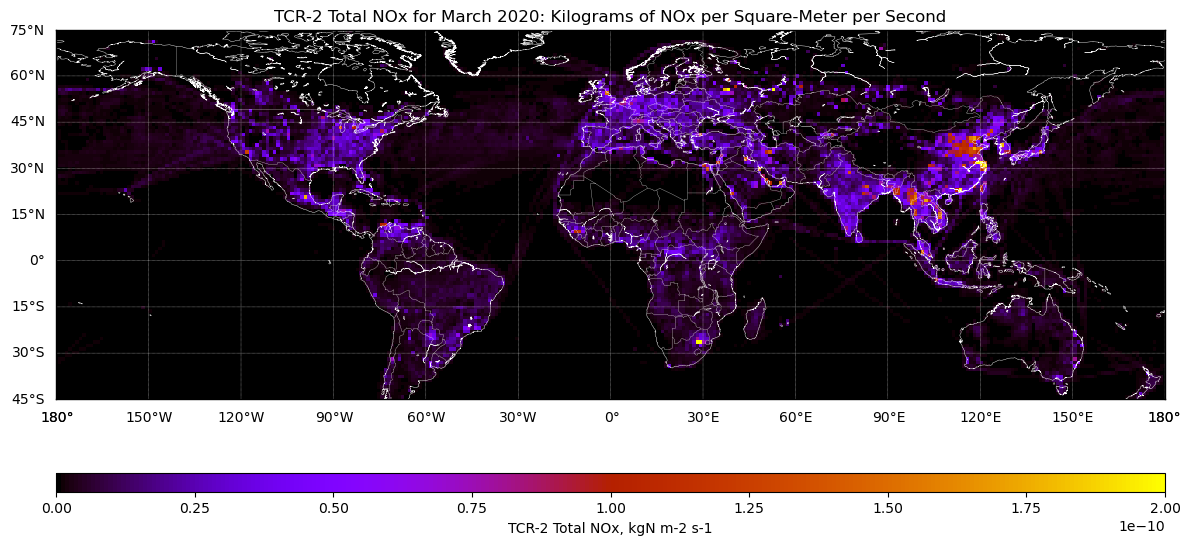

CPU times: user 1.34 s, sys: 41.6 ms, total: 1.38 s
Wall time: 1.39 s


In [11]:
%%time
# Subset data to month/year
selection = np.where(dtime == '2020-03-01T00:00:00')[0]
index = selection[0]

x_meas_mar20 = x_meas[index,:,:]

# Calculate width and height
aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
w = 3600; h = w / aspect_ratio

# Specify figure size (in inches)
dpi = 200; 
plt.figure(figsize=(w / dpi, h / dpi))  

# Create a basemap instance
m = Basemap(projection='cyl', resolution='l',
    llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
    llcrnrlon=longitude_min-180.0, urcrnrlon=longitude_max-180.0)  # set longitude limits as previously defined

m.drawmapboundary(fill_color='black')
m.drawcoastlines(linewidth=0.3, color='white')
m.drawcountries(linewidth=0.2, color='white')

# Draw parallels (latitude lines) and meridians (longitude lines)
parallels = np.arange(latitude_min, latitude_max+1, 15.)
m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3, color='white')

meridians = np.arange(longitude_min, longitude_max+1, 30.)
m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3, color='white')
 
# Plot the interpolated data using pcolormesh instead of scatter
sc = m.pcolormesh(longitude, latitude, x_meas_mar20, latlon=True, cmap='gnuplot', alpha=1.0, vmin=0.0, vmax=2.0e-10, shading='auto')
    
# Add a colorbar
cbar = m.colorbar(sc, location='bottom', pad="20%")
cbar.set_label('TCR-2 Total NOx, kgN m-2 s-1')

# set plot title
plt.title(f'TCR-2 Total NOx for March 2020: Kilograms of NOx per Square-Meter per Second')

# Save figure to PNG file
plt.savefig(f'./data/tcr2_nox_mar_2020.png', dpi=dpi, bbox_inches='tight')

plt.show()
plt.close()

# Let's make a global map (45 deg South to 75 deg North) of the April 2020 NOX Data using Basemap. 

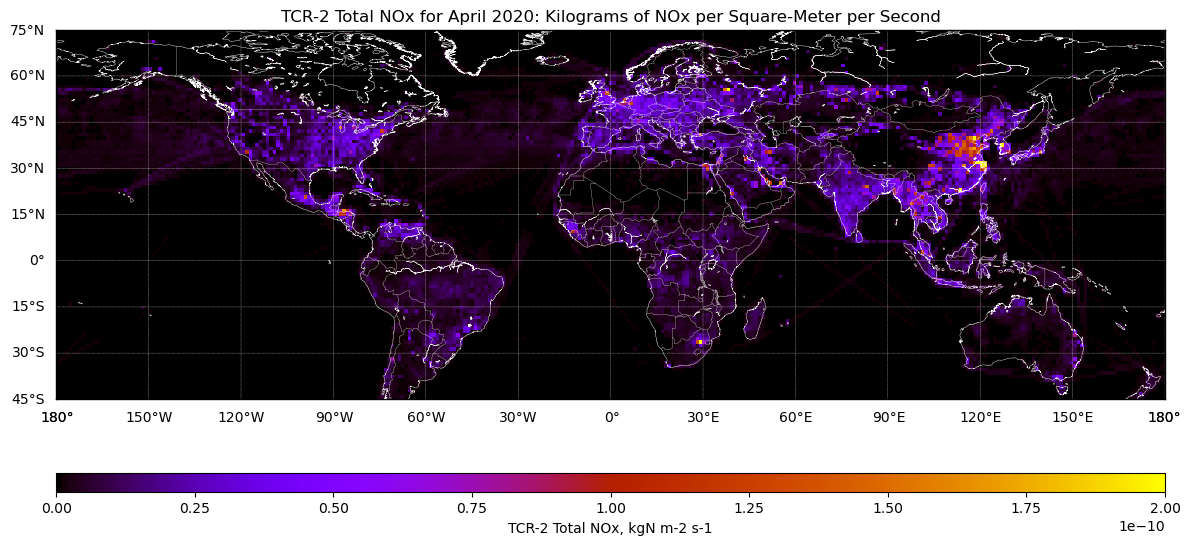

CPU times: user 1.23 s, sys: 28 ms, total: 1.26 s
Wall time: 1.28 s


In [12]:
%%time
# Subset data to month/year
selection = np.where(dtime == '2020-04-01T00:00:00')[0]
index = selection[0]

x_meas_apr20 = x_meas[index,:,:]

# Calculate width and height
aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
w = 3600; h = w / aspect_ratio

# Specify figure size (in inches)
dpi = 200; 
plt.figure(figsize=(w / dpi, h / dpi))  

# Create a basemap instance
m = Basemap(projection='cyl', resolution='l',
    llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
    llcrnrlon=longitude_min-180.0, urcrnrlon=longitude_max-180.0)  # set longitude limits as previously defined

m.drawmapboundary(fill_color='black')
m.drawcoastlines(linewidth=0.3, color='white')
m.drawcountries(linewidth=0.2, color='white')

# Draw parallels (latitude lines) and meridians (longitude lines)
parallels = np.arange(latitude_min, latitude_max+1, 15.)
m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3, color='white')

meridians = np.arange(longitude_min, longitude_max+1, 30.)
m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3, color='white')
 
# Plot the interpolated data using pcolormesh instead of scatter
sc = m.pcolormesh(longitude, latitude, x_meas_apr20, latlon=True, cmap='gnuplot', alpha=1.0, vmin=0.0, vmax=2.0e-10, shading='auto')
    
# Add a colorbar
cbar = m.colorbar(sc, location='bottom', pad="20%")
cbar.set_label('TCR-2 Total NOx, kgN m-2 s-1')

# set plot title
plt.title(f'TCR-2 Total NOx for April 2020: Kilograms of NOx per Square-Meter per Second')

# Save figure to PNG file
plt.savefig(f'./data/tcr2_nox_apr_2020.png', dpi=dpi, bbox_inches='tight')

plt.show()
plt.close()

# Let's make a global map (45 deg South to 75 deg North) of the May 2020 NOX Data using Basemap. 

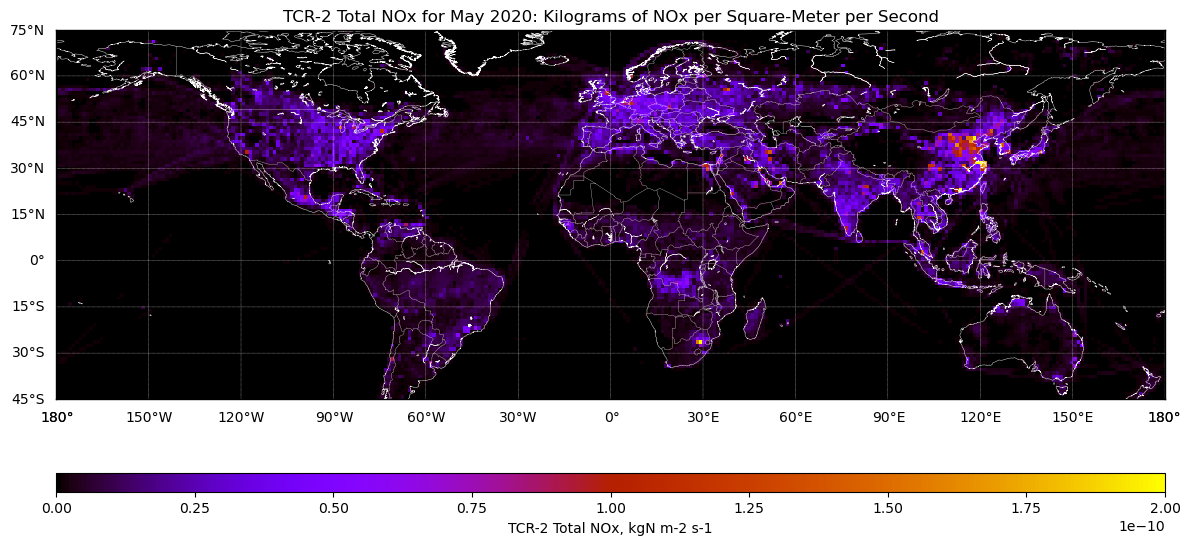

CPU times: user 1.23 s, sys: 7.73 ms, total: 1.23 s
Wall time: 1.25 s


In [13]:
%%time
# Subset data to month/year
selection = np.where(dtime == '2020-05-01T00:00:00')[0]
index = selection[0]

x_meas_may20 = x_meas[index,:,:]

# Calculate width and height
aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
w = 3600; h = w / aspect_ratio

# Specify figure size (in inches)
dpi = 200; 
plt.figure(figsize=(w / dpi, h / dpi))  

# Create a basemap instance
m = Basemap(projection='cyl', resolution='l',
    llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
    llcrnrlon=longitude_min-180.0, urcrnrlon=longitude_max-180.0)  # set longitude limits as previously defined

m.drawmapboundary(fill_color='black')
m.drawcoastlines(linewidth=0.3, color='white')
m.drawcountries(linewidth=0.2, color='white')

# Draw parallels (latitude lines) and meridians (longitude lines)
parallels = np.arange(latitude_min, latitude_max+1, 15.)
m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3, color='white')

meridians = np.arange(longitude_min, longitude_max+1, 30.)
m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3, color='white')
 
# Plot the interpolated data using pcolormesh instead of scatter
sc = m.pcolormesh(longitude, latitude, x_meas_may20, latlon=True, cmap='gnuplot', alpha=1.0, vmin=0.0, vmax=2.0e-10, shading='auto')
    
# Add a colorbar
cbar = m.colorbar(sc, location='bottom', pad="20%")
cbar.set_label('TCR-2 Total NOx, kgN m-2 s-1')

# set plot title
plt.title(f'TCR-2 Total NOx for May 2020: Kilograms of NOx per Square-Meter per Second')

# Save figure to PNG file
plt.savefig(f'./data/tcr2_nox_may_2020.png', dpi=dpi, bbox_inches='tight')

plt.show()
plt.close()

# Let's make a global map (45 deg South to 75 deg North) of the June 2020 NOX Data using Basemap. 

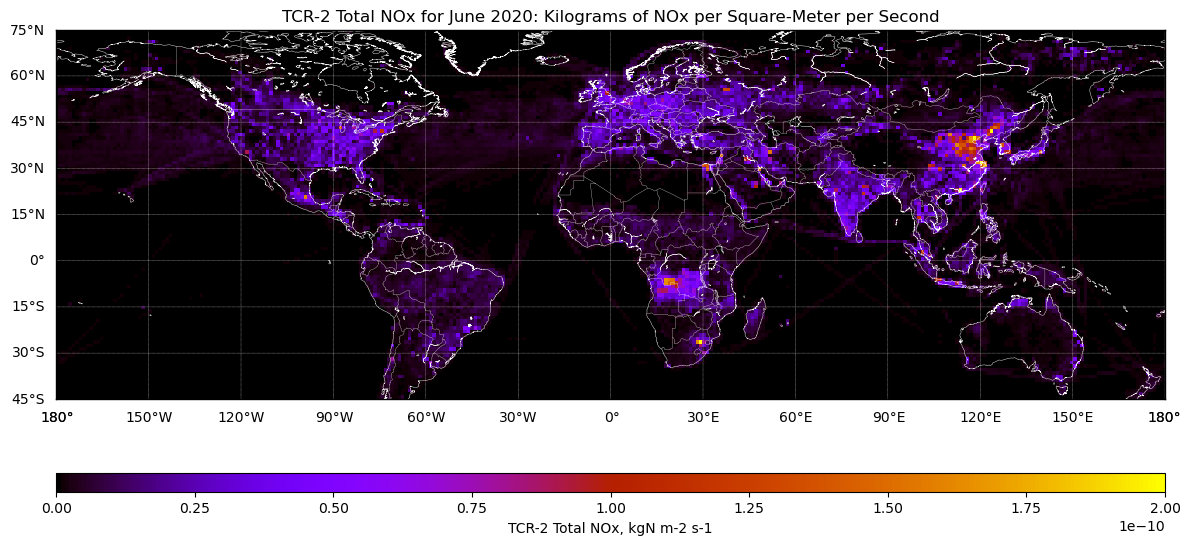

CPU times: user 1.39 s, sys: 10.5 ms, total: 1.4 s
Wall time: 1.51 s


In [14]:
%%time
# Subset data to month/year
selection = np.where(dtime == '2020-06-01T00:00:00')[0]
index = selection[0]

x_meas_jun20 = x_meas[index,:,:]

# Calculate width and height
aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
w = 3600; h = w / aspect_ratio

# Specify figure size (in inches)
dpi = 200; 
plt.figure(figsize=(w / dpi, h / dpi))  

# Create a basemap instance
m = Basemap(projection='cyl', resolution='l',
    llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
    llcrnrlon=longitude_min-180.0, urcrnrlon=longitude_max-180.0)  # set longitude limits as previously defined

m.drawmapboundary(fill_color='black')
m.drawcoastlines(linewidth=0.3, color='white')
m.drawcountries(linewidth=0.2, color='white')

# Draw parallels (latitude lines) and meridians (longitude lines)
parallels = np.arange(latitude_min, latitude_max+1, 15.)
m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3, color='white')

meridians = np.arange(longitude_min, longitude_max+1, 30.)
m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3, color='white')
 
# Plot the interpolated data using pcolormesh instead of scatter
sc = m.pcolormesh(longitude, latitude, x_meas_jun20, latlon=True, cmap='gnuplot', alpha=1.0, vmin=0.0, vmax=2.0e-10, shading='auto')
    
# Add a colorbar
cbar = m.colorbar(sc, location='bottom', pad="20%")
cbar.set_label('TCR-2 Total NOx, kgN m-2 s-1')

# set plot title
plt.title(f'TCR-2 Total NOx for June 2020: Kilograms of NOx per Square-Meter per Second')

# Save figure to PNG file
plt.savefig(f'./data/tcr2_nox_jun_2020.png', dpi=dpi, bbox_inches='tight')

plt.show()
plt.close()

# Let's make a global map (45 deg South to 75 deg North) of the July 2020 NOX Data using Basemap. 

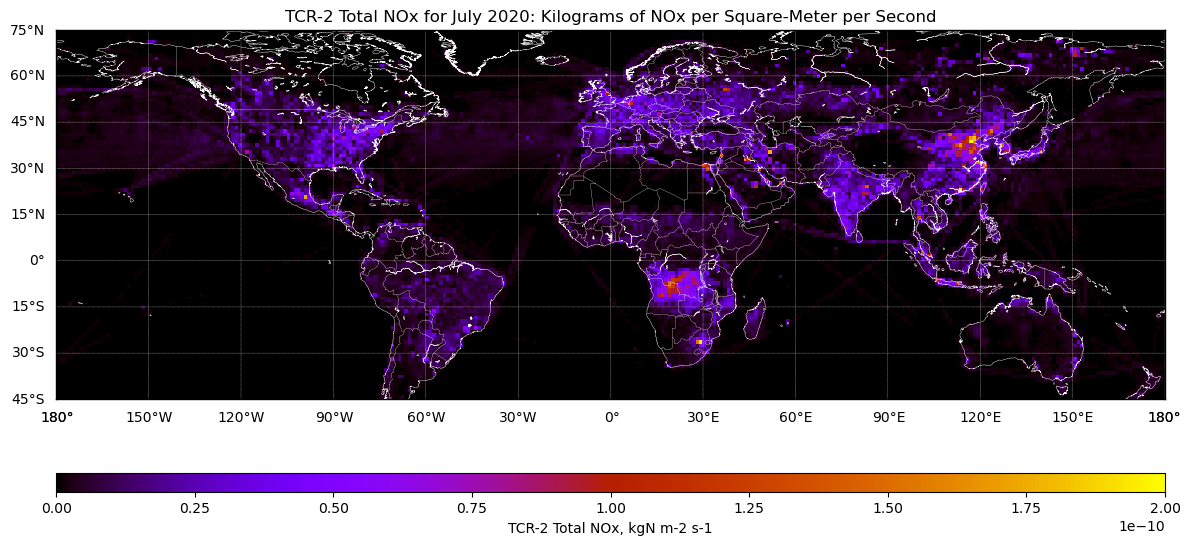

CPU times: user 1.26 s, sys: 29.2 ms, total: 1.29 s
Wall time: 1.51 s


In [15]:
%%time
# Subset data to month/year
selection = np.where(dtime == '2020-07-01T00:00:00')[0]
index = selection[0]

x_meas_jul20 = x_meas[index,:,:]

# Calculate width and height
aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
w = 3600; h = w / aspect_ratio

# Specify figure size (in inches)
dpi = 200; 
plt.figure(figsize=(w / dpi, h / dpi))  

# Create a basemap instance
m = Basemap(projection='cyl', resolution='l',
    llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
    llcrnrlon=longitude_min-180.0, urcrnrlon=longitude_max-180.0)  # set longitude limits as previously defined

m.drawmapboundary(fill_color='black')
m.drawcoastlines(linewidth=0.3, color='white')
m.drawcountries(linewidth=0.2, color='white')

# Draw parallels (latitude lines) and meridians (longitude lines)
parallels = np.arange(latitude_min, latitude_max+1, 15.)
m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3, color='white')

meridians = np.arange(longitude_min, longitude_max+1, 30.)
m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3, color='white')
 
# Plot the interpolated data using pcolormesh instead of scatter
sc = m.pcolormesh(longitude, latitude, x_meas_jul20, latlon=True, cmap='gnuplot', alpha=1.0, vmin=0.0, vmax=2.0e-10, shading='auto')
    
# Add a colorbar
cbar = m.colorbar(sc, location='bottom', pad="20%")
cbar.set_label('TCR-2 Total NOx, kgN m-2 s-1')

# set plot title
plt.title(f'TCR-2 Total NOx for July 2020: Kilograms of NOx per Square-Meter per Second')

# Save figure to PNG file
plt.savefig(f'./data/tcr2_nox_jul_2020.png', dpi=dpi, bbox_inches='tight')

plt.show()
plt.close()

# Let's make a global map (45 deg South to 75 deg North) of the July-March 2020 NOX Difference using Basemap. 

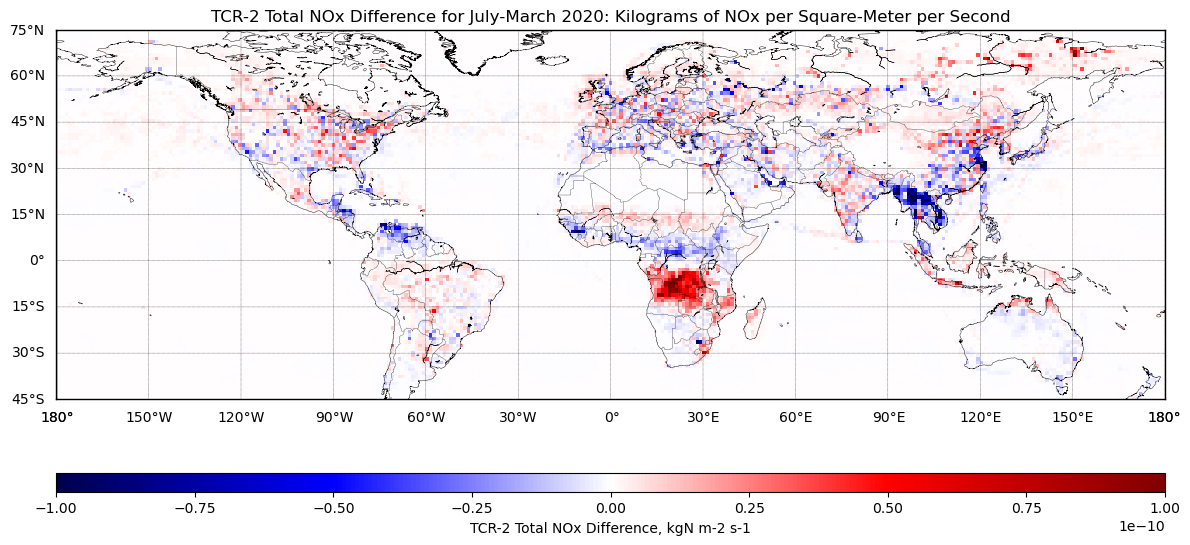

CPU times: user 1.28 s, sys: 15.2 ms, total: 1.3 s
Wall time: 1.42 s


In [16]:
%%time
# Compute the monthly difference
x_meas_diff_jul_mar_20 = x_meas_jul20 - x_meas_mar20

# Calculate width and height
aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
w = 3600; h = w / aspect_ratio

# Specify figure size (in inches)
dpi = 200; 
plt.figure(figsize=(w / dpi, h / dpi))  

# Create a basemap instance
m = Basemap(projection='cyl', resolution='l',
    llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
    llcrnrlon=longitude_min-180.0, urcrnrlon=longitude_max-180.0)  # set longitude limits as previously defined

m.drawmapboundary(fill_color='white')
m.drawcoastlines(linewidth=0.3, color='black')
m.drawcountries(linewidth=0.2, color='black')

# Draw parallels (latitude lines) and meridians (longitude lines)
parallels = np.arange(latitude_min, latitude_max+1, 15.)
m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3, color='black')

meridians = np.arange(longitude_min, longitude_max+1, 30.)
m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3, color='black')
 
# Plot the interpolated data using pcolormesh instead of scatter
sc = m.pcolormesh(longitude, latitude, x_meas_diff_jul_mar_20, latlon=True, cmap='seismic', alpha=1.0, vmin=-1.0e-10, vmax=1.0e-10, shading='auto')
    
# Add a colorbar
cbar = m.colorbar(sc, location='bottom', pad="20%")
cbar.set_label('TCR-2 Total NOx Difference, kgN m-2 s-1')

# set plot title
plt.title(f'TCR-2 Total NOx Difference for July-March 2020: Kilograms of NOx per Square-Meter per Second')

# Save figure to PNG file
plt.savefig(f'./data/tcr2_nox_diff_jul_mar_2020.png', dpi=dpi, bbox_inches='tight')

plt.show()
plt.close()